In [1]:
from typing import (Tuple,List,Dict,Union,Callable)
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scr.activation_funcs import identity, ReLU, sign, tanh
from scr.binary_operators import add, diff, get_x, get_y, multiple, x_is_greater_than_y
import matplotlib.pyplot as plt

In [3]:
# import torch
# from torch.nn import (Tanh,ReLU)

# def dynamics(y_t:torch.tensor,sigma):
    
#     a,b = y_t
#     y_next = torch.zeros_like(y_t)
#     size = y_t.shape[1]
#     relu = ReLU()

#     y_next[0] =  1.0 * torch.tanh(a) + 0.8 * a * b + 1.0 * b - 1.0 * relu(torch.minimum(a,b)) + sigma * torch.randn(size)
#     y_next[1] = 0.6 * torch.sign(b) + 0.5 * a * b - 1.0 * torch.maximum(a,b) + sigma * torch.randn(size)
    
#     return y_next

# sigma_true = 0.1

# T_total = 2000
# y = torch.zeros((2, T_total))
# y_without_noise = torch.zeros((2, T_total))

# name_stock = dynamics(y,sigma_true)
# noise = dynamics(name_stock,0)


# # Nomura = name_stock[0]
# # PFN = name_stock[1]
# name_stock[:,0] = torch.tensor([0.5,0.5])
# noise[:,0] = torch.tensor([0.5,-0.5])
# name_stock_label = ["Nomura", "PFN"]

# plt.figure(figsize=(18,5))
# plt.xlim([T_total-100,T_total])
# plt.plot(name_stock[0].numpy(), color = "#cc0000", label = name_stock_label[0])
# plt.plot(name_stock[1].numpy(), color = "#083090", label = name_stock_label[1])
# plt.plot(noise[0].numpy(), color = "#cc0000", linestyle = "--", label = name_stock_label[0] + "(w/o noise)")
# plt.plot(noise[1].numpy(), color = "#083090", linestyle = "--", label = name_stock_label[1] + "(w/o noise)")
# plt.xlabel("time", fontsize = 18)
# plt.ylabel("y", fontsize = 18)
# plt.legend()

In [27]:
class Trader():
    def __init__(self,
                 num_stock: int,
                 num_factors_max: int,
                 delay_time_max: int,
                 activation_funcs: List[Callable],
                 binary_operators: List[Callable],
                 time_window: int = None) -> None:
        # set hyperparameters
        self.num_stock: int = num_stock  # 股票个数
        self.num_factors_max: int = num_factors_max  # 最大因子数
        self.delay_time_max: int = delay_time_max  # 滞后数 
        self.activation_funcs: List[Callable] = activation_funcs  # 激活函数
        self.binary_operators: List[Callable] = binary_operators  # 二元操作符
        # if time_window==None, train by using all data
        self.time_window: int = time_window

        # GMM字典
        self.dict_activation: Dict = dict(
            zip(activation_funcs, range(len(activation_funcs))))
        self.dict_binary: Dict = dict(
            zip(binary_operators, range(len(binary_operators))))

        # initialize by stock
        # initialized by uniform distribution
        self.num_factors: np.ndarray = np.random.choice(
            range(1, num_factors_max + 1), num_stock)

            
        self.delay_D: np.ndarray = [
            np.random.choice(delay_time_max, i) for i in self.num_factors
        ]
        self.delay_F: np.ndarray = [
            np.random.choice(delay_time_max, i) for i in self.num_factors
        ]

        self.stock_P: List[np.ndarray] = [
            np.random.choice(num_stock, i) for i in self.num_factors
        ]
        self.stock_Q: List[np.ndarray] = [
            np.random.choice(num_stock, i) for i in self.num_factors
        ]

        self.activation_func: List = [
            np.random.choice(activation_funcs, i) for i in self.num_factors
        ]
        self.binary_operator: List = [
            np.random.choice(binary_operators, i) for i in self.num_factors
        ]

        self.w: List[np.ndarray] = [
            np.random.randn(i) for i in self.num_factors
        ]

        self.X_factors: List[np.ndarray] = [
            np.zeros((0, i)) for i in self.num_factors
        ]
        self.cumulative_error: List[np.ndarray] = np.zeros(num_stock)

    def set_params(self, i_stock: int, list_params: List) -> None:
        self.num_factors[i_stock] = list_params[0]["num_factor"]

        self.delay_D[i_stock] = [
            list_params[factor + 1]["delay_P"]
            for factor in range(self.num_factors[i_stock])
        ]
        self.delay_F[i_stock] = [
            list_params[factor + 1]["delay_Q"]
            for factor in range(self.num_factors[i_stock])
        ]
        self.stock_P[i_stock] = [
            list_params[factor + 1]["stock_P"]
            for factor in range(self.num_factors[i_stock])
        ]
        self.stock_Q[i_stock] = [
            list_params[factor + 1]["stock_Q"]
            for factor in range(self.num_factors[i_stock])
        ]
        self.activation_func[i_stock] = [
            self.activation_funcs[list_params[factor + 1]["activation_func"]]
            for factor in range(self.num_factors[i_stock])
        ]
        self.binary_operator[i_stock] = [
            self.binary_operators[list_params[factor + 1]["binary_operator"]]
            for factor in range(self.num_factors[i_stock])
        ]

        self.w[i_stock] = np.random.randn(self.num_factors[i_stock])

        self.X_factors[i_stock] = np.zeros((0, self.num_factors[i_stock]))
        self.cumulative_error[i_stock] = 0.0

    def get_params(self, i_stock: int) -> List[Dict]:
        list_params: List = []
        num_factor: int = self.num_factors[i_stock]
        list_params.append({"num_factor": num_factor})

        for factor in range(num_factor):
            dict_ = {}
            dict_["delay_P"] = self.delay_D[i_stock][factor]
            dict_["delay_Q"] = self.delay_F[i_stock][factor]
            dict_["stock_P"] = self.stock_P[i_stock][factor]
            dict_["stock_Q"] = self.stock_Q[i_stock][factor]
            dict_["activation_func"] = self.dict_activation[
                self.activation_func[i_stock][factor]]
            dict_["binary_operator"] = self.dict_binary[
                self.binary_operator[i_stock][factor]]

            list_params.append(dict_)

        return list_params

    def reset_params(self, i_stock):
        # initialized by uniform distribution
        self.num_factors[i_stock] = np.random.choice(
            range(1, self.num_factors_max + 1))
        self.delay_D[i_stock] = np.random.choice(self.delay_time_max,
                                                 self.num_factors[i_stock])
        self.delay_F[i_stock] = np.random.choice(self.delay_time_max,
                                                 self.num_factors[i_stock])
        self.stock_P[i_stock] = np.random.choice(self.num_stock,
                                                 self.num_factors[i_stock])
        self.stock_Q[i_stock] = np.random.choice(self.num_stock,
                                                 self.num_factors[i_stock])
        self.activation_func[i_stock] = np.random.choice(
            self.activation_funcs, self.num_factors[i_stock])
        self.binary_operator[i_stock] = np.random.choice(
            self.binary_operators, self.num_factors[i_stock])
        self.w[i_stock] = np.random.randn(self.num_factors[i_stock])

        self.X_factors[i_stock] = np.zeros((0, self.num_factors[i_stock]))
        self.cumulative_error[i_stock] = 0.0

    def calc_factor(self, data: List, i_stock: int, j: int):
        """ 计算关于第i_stock股票的第j项
        """
        Aj = self.activation_func[i_stock][j]
        Oj = self.binary_operator[i_stock][j]
        Pj = self.stock_P[i_stock][j]
        Qj = self.stock_Q[i_stock][j]
        Dj = self.delay_D[i_stock][j]
        Fj = self.delay_F[i_stock][j]
        return Aj(
            Oj(data[Pj][self.delay_time_max - Dj],
               data[Qj][self.delay_time_max - Fj]))

    def calc_factors(self, data, i_stock) -> np.ndarray:

        num_factors = self.num_factors[i_stock]

        # 每个因素
        factors: np.ndarray = np.array(
            [self.calc_factor(data, i_stock, j) for j in range(num_factors)])

        return factors

    def stack_factors(self, data: List, i_stock: int)->None:
        """
        将计算了time_window 的数目的项(factors)保存到x_factors中
        如果超过time_window,则删除旧的factors,并将最新的factors保存在底部
        """
        factors: np.ndarray = self.calc_factors(data, i_stock)

        if self.time_window is None:

            self.X_factors[i_stock] = np.vstack(
                [self.X_factors[i_stock], factors])

        elif len(self.X_factors[i_stock]) < self.time_window:

            self.X_factors[i_stock] = np.vstack(
                [self.X_factors[i_stock], factors])
        else:
            #
            self.X_factors[i_stock] = np.roll(self.X_factors[i_stock],
                                              -1,
                                              axis=0)
            self.X_factors[i_stock][-1] = factors
        # return None

    def learn(self, y, i_stock)->None:
        epsilon = 0.0001
        X = self.X_factors[i_stock]
        if self._check_rank_deficient(i_stock):
            self.w[i_stock] = np.zeros(len(self.w[i_stock]))
        else:
            self.w[i_stock] = np.linalg.inv(X.T.dot(X) + epsilon).dot(
                X.T).dot(y)

    def _check_rank_deficient(self, i_stock)->bool:
        """ 确认排名下降
        """
        X = self.X_factors[i_stock]
        return np.linalg.matrix_rank(X.T.dot(X)) < self.num_factors[i_stock]

    # 对test data进行测试，并在此基础上对模型进行评估．
    def predict(self)->np.ndarray:
        """ 使用最新的factors预测来预测下一个时间
        """
        # y_pred = np.zeros(self.num_stock)
        y_pred: np.ndarray = np.array([
            self.X_factors[i_stock][-1].dot(self.w[i_stock])
            for i_stock in range(self.num_stock)
        ])
        # for i_stock in range(self.num_stock):
        #     y_pred[i_stock] = self.X_factors[i_stock][-1].dot(self.w[i_stock])
        return y_pred

    def predict_for_X_factors(self)->np.ndarray:
        """ len(X_factors) < time_window时出错
        """
        # if len(self.X_factors) < self.time_window:

        #     raise ValueError('X_factors长度少于time_window')

        # y_preds = np.zeros((self.num_stock, self.time_window))

        y_preds: np.ndarray = np.array([
            self.X_factors[i_stock].dot(self.w[i_stock])
            for i_stock in range(self.num_stock)
        ])
        # for i_stock in range(self.num_stock):
        #     y_preds[i_stock] = self.X_factors[i_stock].dot(self.w[i_stock])
        return y_preds

    def calc_cumulative_error(self, y_true):
        y_preds = self.predict_for_X_factors()
        errors:float = np.power(y_preds - y_true,2)
        errors = np.sqrt(errors.mean(1))
        for i_stock in range(self.num_stock):
            self.cumulative_error[i_stock] = errors[i_stock]
        return self.cumulative_error


In [28]:
from sklearn import mixture, preprocessing


class Company:
    def __init__(self,
                 stock_names:List[str],
                 num_factors_max:int,
                 delay_time_max:int,
                 activation_funcs:List[Callable],
                 binary_operators:List[Callable],
                 num_traders:int,
                 Q:float=0.2,
                 time_window:int=None,
                 how_recruit:str="random"):
        
        """time_window应该大于num_factors_max

            1-q 代表bad_traders的百分比,也就是说Q越大,被解雇的百分比就越小.(Q即存活率)

            我试过把所有人都变成坏人，但没有意义
        """
        self.stock_names:List[str] = stock_names
        self.num_stock:int = len(stock_names)
        self.num_factors_max:int = num_factors_max
        self.delay_time_max:int = delay_time_max
        self.activation_funcs:List[Callable] = activation_funcs
        self.binary_operators:List[Callable] = binary_operators
        self.num_traders:int = num_traders
        self.Q:float = Q
        # if time_window==None, train by using all data
        self.time_window:int = time_window
        self.how_recruit:str = how_recruit

        self.df_y_train:pd.DataFrame = None

        self.initialize_traders()  # 初始化trader

    def fit(self, df_y_train: pd.DataFrame):
        if self.df_y_train is not None:
            raise ValueError("df_y_train不能为空")
        
        self.df_y_train = df_y_train
        y_train:np.ndarray = self.df_y_train.T.values

        for t in tqdm(range(self.delay_time_max + 1, len(self.df_y_train))):
            data_to_stack = y_train[:, t - self.delay_time_max - 1:t]

            self.observe(data_to_stack)

            if self.delay_time_max + 1 + self.time_window < t <= len(
                    self.df_y_train):
                y_true = y_train[:, t - self.time_window + 1:t + 1]
                self.educate(y_true)
                self.fire_and_recruit(t, y_true)

        # 最后一个时刻 t 的数据显示educate只能是 stock，因为没有 t + 1的数据可用
        # stock否则我们在用 self.agomez 预测时会用到 t-1的数据来预测时间 t
        data_to_stack = y_train[:, t - self.delay_time_max:t + 1]
        self.observe(data_to_stack)

    def fit_new_data(self, dict_y, tuning=False):
        # 最初にdf_y_trainにデータを追加。この時点では計算されていない。
        self.add_new_data(dict_y)

        # tuning=Trueであれば、新しいデータを使用して再度educate&fire_recruitを実施する
        if tuning:
            self.educate_fire_recruit_by_new_data()

        # 新しいデータを用いてfactorを計算する
        self.observe_new_data()

    def add_new_data(self, dict_y):
        self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)

    def educate_fire_recruit_by_new_data(self):
        # 一番最新のデータから教育
        t = len(self.df_y_train)
        y_train = self.df_y_train.T.values
        y_true = y_train[:, t - self.time_window:t]
        self.educate(y_true)
        self.fire_and_recruit(t - 1, y_true)

    def observe_new_data(self):
        # 一番最新のデータをobserve
        t = len(self.df_y_train)
        y_train = self.df_y_train.T.values
        data_to_stack = y_train[:, t - self.delay_time_max - 1:t]
        self.observe(data_to_stack)

    def initialize_traders(self):
        """初始化Trader"""

        model = Trader(
                self.num_stock, self.num_factors_max, self.delay_time_max,
                self.activation_funcs, self.binary_operators, self.time_window)
        
        self.traders = [model] * self.num_traders


    def generate_trader_without_singular_initialize_params(
            self, i_trader, i_stock, t):
        y_train = self.df_y_train.T.values
        for i_stock in range(self.num_stock):
            self.traders[i_trader].reset_params(i_stock)
            for idx in reversed(range(self.time_window)):
                self.traders[i_trader].stack_factors(
                    y_train[:, t - self.delay_time_max - 1 - idx:t - idx],
                    i_stock)
            while self.traders[i_trader]._check_rank_deficient(i_stock):
                self.traders[i_trader].reset_params(i_stock)
                for idx in reversed(range(self.time_window)):
                    self.traders[i_trader].stack_factors(
                        y_train[:, t - self.delay_time_max - 1 - idx:t - idx],
                        i_stock)

    def generate_trader_without_singular(self, i_trader, i_stock, t,
                                         vbgmm_num_factor,
                                         vbgmm_factor_params):
        
        y_train = self.df_y_train.T.values
        for i_stock in range(self.num_stock):
            list_params = self.sample_params(vbgmm_num_factor,
                                             vbgmm_factor_params)
            self.traders[i_trader].set_params(i_stock, list_params)
            for idx in reversed(range(self.time_window)):
                self.traders[i_trader].stack_factors(
                    y_train[:, t - self.delay_time_max - 1 - idx:t - idx],
                    i_stock)
            while self.traders[i_trader]._check_rank_deficient(i_stock):
                list_params = self.sample_params(vbgmm_num_factor,
                                                 vbgmm_factor_params)
                self.traders[i_trader].set_params(i_stock, list_params)
                for idx in reversed(range(self.time_window)):
                    self.traders[i_trader].stack_factors(
                        y_train[:, t - self.delay_time_max - 1 - idx:t - idx],
                        i_stock)

    def observe(self, data:List):
        """计算factors并保存所有trader的排名
        """
        # for i_trader in range(self.num_traders):
        #     for i_stock in range(self.num_stock):
        #         self.traders[i_trader].stack_factors(data, i_stock)

        for trader in self.traders:
            
            for i_stock in range(self.num_stock):
                
                trader.stack_factors(data,i_stock)

        
    def educate(self, y_true):
        """ 训练错误率低于底层Q%的交易员"""
        
        bad_traders = self.find_bad_traders(y_true, 1 - self.Q)
        for i_trader in range(self.num_traders):
            for i_stock in range(self.num_stock):
                if bad_traders[i_stock][i_trader]:
                    self.traders[i_trader].learn(y_true[i_stock], i_stock)

    def find_bad_traders(self, y_true, Q):
        """ 找出错误率低于前Q%的交易员"""
        
        cumulative_errors = np.zeros((self.num_stock, self.num_traders))
        for i_trader in range(self.num_traders):
            for i_stock in range(self.num_stock):
                self.traders[i_trader].calc_cumulative_error(y_true)
                cumulative_errors[i_stock][i_trader] = self.traders[
                    i_trader].cumulative_error[i_stock]

        bad_traders = np.ones((self.num_stock, self.num_traders)) > 0.0
        for i_stock in range(self.num_stock):
            bad_traders[i_stock] = cumulative_errors[i_stock] > np.percentile(
                cumulative_errors[i_stock], 100. * Q)
        return bad_traders

    def fire_and_recruit(self, t, y_true):
        """ 解雇、补充错误率低于前Q% 的交易员"""
        
        if self.how_recruit == "gmm":
            list_vbgmm = []
            good_traders = ~self.find_bad_traders(y_true, 1 - self.Q)
            for i_stock in range(self.num_stock):
                list_vbgmm.append(self.fit_vbgmm(i_stock, good_traders))

        bad_traders = self.find_bad_traders(y_true, self.Q)
        for i_trader in range(self.num_traders):
            for i_stock in range(self.num_stock):
                if bad_traders[i_stock][i_trader]:
                    if self.how_recruit == "gmm":
                        self.generate_trader_without_singular(
                            i_trader, i_stock, t, list_vbgmm[i_stock][0],
                            list_vbgmm[i_stock][1])
                    else:
                        self.generate_trader_without_singular_initialize_params(
                            i_trader, i_stock, t)
                    self.traders[i_trader].calc_cumulative_error(y_true)

    def sample_params(self, vbgmm_num_factor, vbgmm_factor_params):
        list_params = []
        num_factor = np.vectorize(round)(vbgmm_num_factor.sample(1)[0][0])[0]
        num_factor = self.check_param(num_factor, 1, self.num_factors_max)
        list_params.append({"num_factor": num_factor})
        for i_factor in range(num_factor):
            factor_params = np.vectorize(round)(
                vbgmm_factor_params.sample(1)[0])[0]
            dict_params = {}
            for key, value in zip([
                    "delay_P", "delay_Q", "stock_P", "stock_Q",
                    "activation_func", "binary_operator"
            ], factor_params):
                if key in ["delay_P", "delay_Q"]:
                    dict_params[key] = self.check_param(
                        value, 0, self.delay_time_max - 1)
                elif key in ["stock_P", "stock_Q"]:
                    dict_params[key] = self.check_param(
                        value, 0, self.num_stock - 1)
                elif key == "activation_func":
                    dict_params[key] = self.check_param(
                        value, 0,
                        len(self.activation_funcs) - 1)
                elif key == "binary_operator":
                    dict_params[key] = self.check_param(
                        value, 0,
                        len(self.binary_operators) - 1)
            list_params.append(dict_params)
        return list_params

    def check_param(self, param_, min_, max_):
        if param_ < min_:
            param_ = min_
        elif param_ > max_:
            param_ = max_
        else:
            param_ = param_
        return param_

    def fit_vbgmm(self, i_stock, good_traders):
        """ good_traders[i_stock]のTraderのパラメータのみでFittingする
        """
        df_num_factor = pd.DataFrame(columns=["num_factor"])
        df_factor_params = pd.DataFrame(columns=[
            "delay_P", "delay_Q", "stock_P", "stock_Q", "activation_func",
            "binary_operator"
        ])
        for i_trader, trader in enumerate(self.traders):
            if good_traders[i_stock][i_trader]:
                list_params = trader.get_params(i_stock)
                dict_num_factor = list_params[0]
                df_num_factor = df_num_factor.append(dict_num_factor,
                                                     ignore_index=True)

                for i_factor in range(dict_num_factor["num_factor"]):
                    dict_factor_params = list_params[i_factor + 1]
                    df_factor_params = df_factor_params.append(
                        dict_factor_params, ignore_index=True)
        print(df_factor_params)
        vbgmm_num_factor = self.VBGMM(df_num_factor,
                                      n_components=self.num_stock)
        vbgmm_factor_params = self.VBGMM(df_factor_params, n_components=3)

        return vbgmm_num_factor, vbgmm_factor_params

    def VBGMM(self, X, n_components=10):
        model = mixture.BayesianGaussianMixture(n_components=n_components)
        return model.fit(X)

    def aggregate(self):
        predictions = np.zeros((self.num_stock, self.num_traders))
        weights = np.zeros((self.num_stock, self.num_traders))

        bad_traders = np.ones((self.num_stock, self.num_traders)) > 0.0
        for i_stock in range(self.num_stock):
            cumulative_errors = np.array(
                [trader.cumulative_error[i_stock] for trader in self.traders])
            bad_traders[i_stock] = cumulative_errors > np.percentile(
                cumulative_errors, 100. * self.Q)

        for i_trader in range(self.num_traders):
            for i_stock in range(self.num_stock):
                if not bad_traders[i_stock][
                        i_trader]:  # Q-パーセンタイル以上の成績の良いTraderのみを対象
                    weights[i_stock][i_trader] = (
                        1.0 / self.traders[i_trader].cumulative_error[i_stock])
                    predictions[i_stock][i_trader] = self.traders[
                        i_trader].predict()[i_stock]

        predictions_weighted = np.zeros(self.num_stock)
        for i_stock in range(self.num_stock):
            predictions_weighted[i_stock] = (weights[i_stock] *
                                             predictions[i_stock]).sum() / (
                                                 weights[i_stock].sum())
        return predictions_weighted


# 设置数据

In [4]:
def create_dataset(T, sigma_t):
    def simulation(y_t, sigma):
        y_t1 = np.zeros(2)
        y_t1[0] = 1.0*tanh(y_t[0]) + 0.8*y_t[0]*y_t[1] + 1.0*y_t[1] - 1.0*ReLU(min(y_t[0], y_t[1])) + sigma*np.random.randn()
        y_t1[1] = +0.6*sign(y_t[1]) + 0.5*y_t[0]*y_t[1] - 1.0*max(y_t[0], y_t[1]) + sigma*np.random.randn()
        return y_t1
    
    y = np.zeros((2, T))
    y_without_noise = np.zeros((2, T))
    y[:,0] = np.array([0.1, 0.1])
    y_without_noise[:,0] = np.array([0.1, 0.1])
    
    for t in range(1, T):
        y[:,t] = simulation(y[:,t-1], sigma_t)
        y_without_noise[:,t] = simulation(y[:,t-1], 0.0)
    
    plt.plot(y[0], color = "#cc0000", label = "stock0")
    plt.plot(y[1], color = "#083090", label = "stock1")
    plt.plot(y_without_noise[0], color = "#cc0000", linestyle = "--", label = "stock0" + "(w/o noise)")
    plt.plot(y_without_noise[1], color = "#083090", linestyle = "--", label = "stock1" + "(w/o noise)")
    plt.xlabel("time", fontsize = 18)
    plt.ylabel("y", fontsize = 18)
    plt.xlim([T-100, T])
    plt.legend()
    plt.show()
    plt.close()
    
    return y, y_without_noise

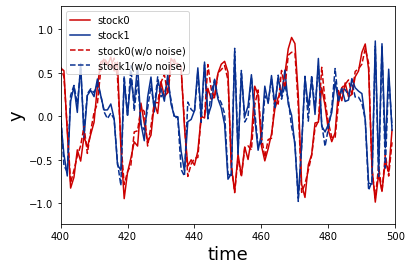

In [5]:
sigma = 0.1
T_total = 500
y, y_without_noise = create_dataset(T_total, sigma)

In [6]:
df_y = pd.DataFrame(y, index=["stock0", "stock1"]).T

df_y.head()

,stock0,stock1
0,0.100000,0.100000
1,0.191370,0.313573
2,0.384630,0.332298
3,0.574438,0.352617
4,0.768387,0.012422


# 训练

In [29]:
activation_funcs = [identity, ReLU, sign, tanh]
binary_operators = [max, min, add, diff, multiple, get_x, get_y, x_is_greater_than_y]

stock_names = ["stock0", "stock1"]
time_window = 200
delay_time_max = 2
num_factors_max = 4

model = Company(stock_names, 
                num_factors_max, 
                delay_time_max, 
                activation_funcs, 
                binary_operators, 
                num_traders=40, 
                Q=0.2, 
                time_window=time_window, 
                how_recruit="random")

In [30]:
T_train = 400
df_y_train = df_y.iloc[:T_train, :]
df_y_test = df_y.iloc[T_train:, :]

In [31]:
model.fit(df_y_train)

  0%|          | 0/397 [00:00<?, ?it/s]

In [32]:
model.aggregate()

array([0.01194506, 0.        ])

In [39]:
model.traders[0].w

[array([0.02347847]), array([0.32984757])]

In [171]:
# for i,trader_model in enumerate(model.traders):
    
#     print(i,len(trader_model.num_factors))

# 测试

In [33]:
errors_test_notuning = []
for i, row in tqdm(df_y_test.iterrows()):
    prediction_test = model.aggregate()
    errors_test_notuning.append(np.abs(row.values - prediction_test))
    
    # tuning==Falseの場合、データが追加されても重みの更新などパラメータは変わらない
    model.fit_new_data(row.to_dict(), tuning=False)

errors_test_tuning = []
for i, row in tqdm(df_y_test.iterrows()):
    prediction_test = model.aggregate()
    errors_test_tuning.append(np.abs(row.values - prediction_test))
    
    # tuning==Trueの場合、データが追加された際に重みの更新などパラメータが調整される
    model.fit_new_data(row.to_dict(), tuning=True)

0it [00:00, ?it/s]

C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

0it [00:00, ?it/s]

C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

In [34]:
days_ma = 5

# trader-company errors with no-tuning
errors_test_notuning = np.array(errors_test_notuning)
errors_test_notuning_ma = pd.DataFrame(errors_test_notuning).rolling(days_ma).mean()

# trader-company errors with tuning
errors_test_tuning = np.array(errors_test_tuning)
errors_test_tuning_ma = pd.DataFrame(errors_test_tuning).rolling(days_ma).mean()

# baseline method
errors_baseline = np.abs(y[:,T_train+1:] - y[:,T_train:-1])
errors_baseline_ma = pd.DataFrame(errors_baseline.T).rolling(days_ma).mean()

# lower bound
errors_lower_bound = np.abs(y[:,T_train+1:] - y_without_noise[:,T_train+1:])
errors_lower_bound_ma = pd.DataFrame(errors_lower_bound.T).rolling(days_ma).mean()

stock0


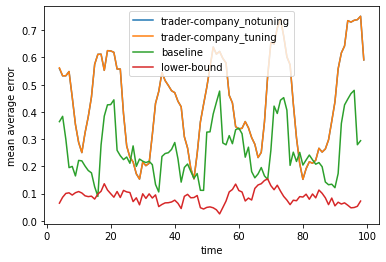

stock1


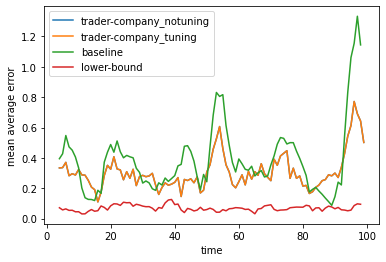

In [36]:
for i_stock, name in enumerate(stock_names):
    print(name)
    plt.plot(errors_test_notuning_ma[i_stock], label="trader-company_notuning")
    plt.plot(errors_test_tuning_ma[i_stock], label="trader-company_tuning")
    plt.plot(errors_baseline_ma[i_stock], label="baseline")
    plt.plot(errors_lower_bound_ma[i_stock], label="lower-bound")
    plt.xlabel("time")
    plt.ylabel("mean average error")
    plt.legend()
    plt.show()